In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,plot_xgb_feature_importance


In [4]:
sheet = pd.read_excel('data_input/中国汽柴油出口计划量.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet[['中国汽油出口计划量', '中国柴油出口计划量']].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=1, freq='ME')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='ME')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,中国汽油出口计划量,汽油：产出率：中国：主营炼厂（周）/4WMA同差,新加坡92#汽油裂解价差,中国汽油产量同差,新加坡10ppm柴油裂解,柴油：主营炼厂：产量：中国（周）同差,中国柴油库存4周环差,（中国独立炼厂柴油库存+中国主营成品油销售公司柴油库存）/中国柴油实际消费量/4WMA,中国柴油出口计划量,汽油出口利润-柴油出口利润,汽油出口利润（华东-新加坡）,柴油出口利润（华东-新加坡）,中国主营炼厂汽油产量超季节性/3年,中国主营炼厂汽油产量4周环差超季节性/3年/4WMA
2025-11-05,NaN,NaN,14.36,NaN,25.12,NaN,NaN,NaN,NaN,-170.5943,424.5043,595.0986,NaN,NaN
2025-11-06,NaN,NaN,14.39,NaN,26.18,NaN,NaN,NaN,NaN,-231.4098,395.8277,627.2375,NaN,NaN
2025-11-07,NaN,-1.0781,15.03,-10.2366,27.65,-19.128,-68.4,1.9441,NaN,NaN,NaN,NaN,-3.1251,5.8717
2025-11-30,34.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.4,NaN,NaN,NaN,NaN,NaN
2025-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
sheet.columns

Index(['中国汽油出口计划量', '汽油：产出率：中国：主营炼厂（周）/4WMA同差', '新加坡92#汽油裂解价差', '中国汽油产量同差',
       '新加坡10ppm柴油裂解', '柴油：主营炼厂：产量：中国（周）同差', '中国柴油库存4周环差',
       '（中国独立炼厂柴油库存+中国主营成品油销售公司柴油库存）/中国柴油实际消费量/4WMA', '中国柴油出口计划量',
       '汽油出口利润-柴油出口利润', '汽油出口利润（华东-新加坡）', '柴油出口利润（华东-新加坡）',
       '中国主营炼厂汽油产量超季节性/3年', '中国主营炼厂汽油产量4周环差超季节性/3年/4WMA'],
      dtype='object')

In [6]:
# 将数据转换为月度数据（每月最后一天）
sheet = sheet.resample('ME').agg({
    '中国汽油出口计划量': 'last',  # 取最后一个值
    '中国柴油出口计划量': 'last',
    '汽油：产出率：中国：主营炼厂（周）/4WMA同差': 'mean',  # 高频数据取平均
    '新加坡92#汽油裂解价差': 'mean',  # 高频数据取平均
    '中国汽油产量同差': 'mean',  # 高频数据取平均
    '新加坡10ppm柴油裂解': 'mean',  # 高频数据取平均
    '柴油：主营炼厂：产量：中国（周）同差': 'mean',  # 高频数据取平均
    '中国柴油库存4周环差': 'mean' , # 高频数据取平均
    '（中国独立炼厂柴油库存+中国主营成品油销售公司柴油库存）/中国柴油实际消费量/4WMA': 'mean',
    '汽油出口利润-柴油出口利润': 'mean',
    '汽油出口利润（华东-新加坡）':'mean', 
    '柴油出口利润（华东-新加坡）':'mean',
    '中国主营炼厂汽油产量超季节性/3年':'mean',
     '中国主营炼厂汽油产量4周环差超季节性/3年/4WMA':'mean'
})

# 确保索引是每月最后一天
sheet.index = sheet.index + pd.offsets.MonthEnd(0)


In [7]:
################################# 处理缺失值 #################################
fill_methods = {
'汽油：产出率：中国：主营炼厂（周）/4WMA同差': 'interpolate', 
'新加坡92#汽油裂解价差': 'interpolate', 
'中国汽油产量同差': 'interpolate',
'新加坡10ppm柴油裂解': 'interpolate', 
'柴油：主营炼厂：产量：中国（周）同差': 'interpolate', 
'中国柴油库存4周环差': 'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, '中国汽油出口计划量'] = sheet.loc[:last_day, '中国汽油出口计划量'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['汽油：产出率：中国：主营炼厂（周）/4WMA同差_提前1月'] = sheet['汽油：产出率：中国：主营炼厂（周）/4WMA同差'].shift(1)
sheet['新加坡92#汽油裂解价差_提前2月'] = sheet['新加坡92#汽油裂解价差'].shift(3)
sheet['中国汽油产量同差_提前1月'] = sheet['中国汽油产量同差'].shift(1)
sheet['新加坡10ppm柴油裂解_提前2月'] = sheet['新加坡10ppm柴油裂解'].shift(2)
sheet['柴油：主营炼厂：产量：中国（周）同差_提前2月'] = sheet['柴油：主营炼厂：产量：中国（周）同差'].shift(2)
sheet['中国柴油库存4周环差_提前1月'] = sheet['中国柴油库存4周环差'].shift(1)
sheet['（中国独立炼厂柴油库存+中国主营成品油销售公司柴油库存）/中国柴油实际消费量/4WMA_提前1月'] = sheet['（中国独立炼厂柴油库存+中国主营成品油销售公司柴油库存）/中国柴油实际消费量/4WMA'].shift(1)
sheet['汽油出口利润-柴油出口利润_提前1月'] = sheet['汽油出口利润-柴油出口利润'].shift(1)
sheet['汽油出口利润（华东-新加坡）_提前3月'] = sheet['汽油出口利润（华东-新加坡）'].shift(3)
sheet['汽油出口利润-柴油出口利润_提前2月'] = sheet['汽油出口利润-柴油出口利润'].shift(2)
sheet['柴油出口利润（华东-新加坡）_提前2月'] = sheet['柴油出口利润（华东-新加坡）'].shift(2)
sheet['中国主营炼厂汽油产量超季节性/3年_提前1月'] = sheet['中国主营炼厂汽油产量超季节性/3年'].shift(1)
sheet['中国主营炼厂汽油产量4周环差超季节性/3年/4WMA_提前2月'] = sheet['中国主营炼厂汽油产量4周环差超季节性/3年/4WMA'].shift(2)


sheet['新加坡10ppm柴油裂解_提前30天'] = sheet['新加坡10ppm柴油裂解'].shift(30)

sheet['汽油出口利润-柴油出口利润_提前1月_逆序'] = reverse_column(sheet, '汽油出口利润-柴油出口利润_提前1月')

################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['中国汽油出口计划量'].notna() | sheet_daily['中国柴油出口计划量'].notna())
]

################################# 数据 读取-处理 结束 #################################
sheet_daily.tail()

,Date,中国汽油出口计划量,中国柴油出口计划量,（中国独立炼厂柴油库存+中国主营成品油销售公司柴油库存）/中国柴油实际消费量/4WMA,汽油出口利润-柴油出口利润,汽油出口利润（华东-新加坡）,柴油出口利润（华东-新加坡）,中国主营炼厂汽油产量超季节性/3年,中国主营炼厂汽油产量4周环差超季节性/3年/4WMA,汽油：产出率：中国：主营炼厂（周）/4WMA同差,...,中国柴油库存4周环差_提前1月,（中国独立炼厂柴油库存+中国主营成品油销售公司柴油库存）/中国柴油实际消费量/4WMA_提前1月,汽油出口利润-柴油出口利润_提前1月,汽油出口利润（华东-新加坡）_提前3月,汽油出口利润-柴油出口利润_提前2月,柴油出口利润（华东-新加坡）_提前2月,中国主营炼厂汽油产量超季节性/3年_提前1月,中国主营炼厂汽油产量4周环差超季节性/3年/4WMA_提前2月,新加坡10ppm柴油裂解_提前30天,汽油出口利润-柴油出口利润_提前1月_逆序
31,2025-08-31,48.9,74.6,2.359400,-98.400033,-181.964700,-83.564667,-13.932600,-4.94468,-2.43684,...,53.7525,2.261825,-297.988996,-147.428428,104.250200,-293.178445,-11.017675,3.327575,24.752500,990.520481
32,2025-09-30,59.6,58.5,2.134575,-91.554555,50.838973,142.393527,-11.580875,0.84690,-1.64625,...,28.4260,2.359400,-98.400033,-188.928245,-297.988996,47.346083,-13.932600,2.561275,23.889130,790.931519
33,2025-10-31,60.4,60.4,1.997060,-108.746763,203.134881,311.881644,-4.024180,5.67216,-1.23194,...,-16.3150,2.134575,-91.554555,-250.642913,-98.400033,-83.564667,-11.580875,-4.944680,15.425789,784.086040
34,2025-11-30,34.1,30.4,1.944100,-152.252500,444.097575,596.350075,-3.125100,5.87170,-1.07810,...,-39.9100,1.997060,-108.746763,-181.964700,-91.554555,142.393527,-4.024180,0.846900,14.839130,801.278248
35,2025-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.07810,...,-68.4000,1.944100,-152.252500,50.838973,-108.746763,311.881644,-3.125100,5.672160,16.870000,844.783986


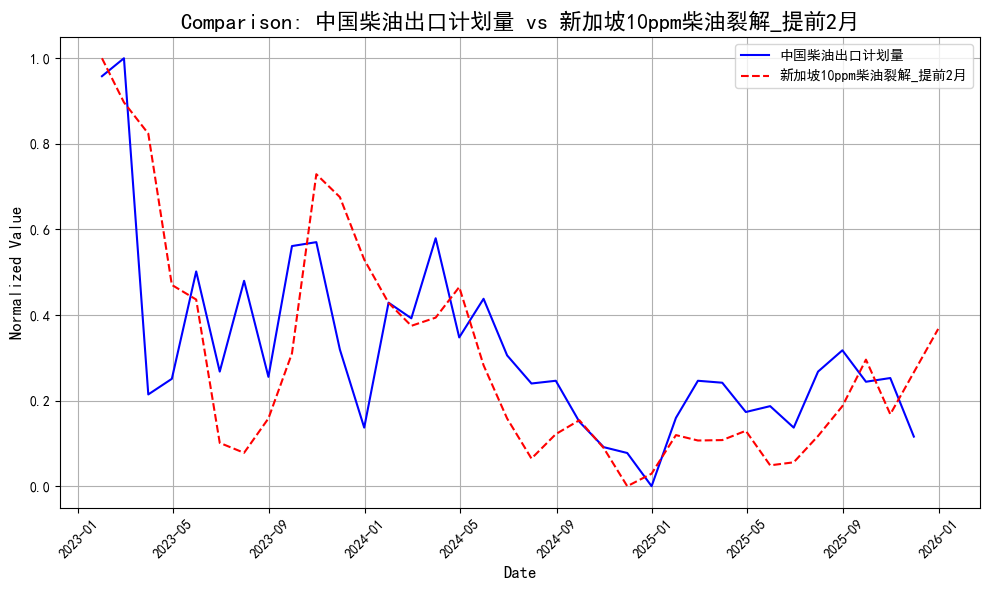

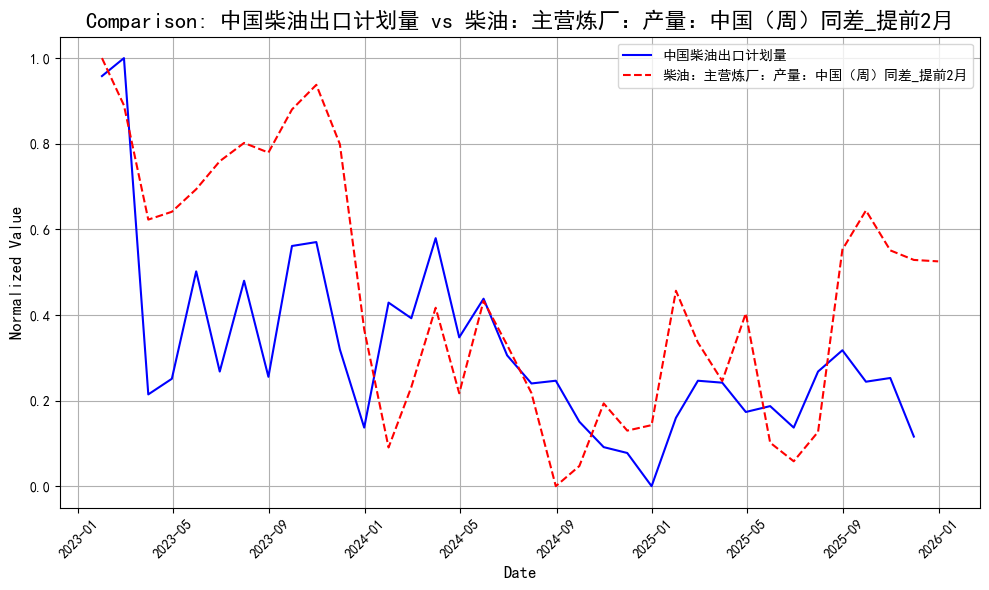

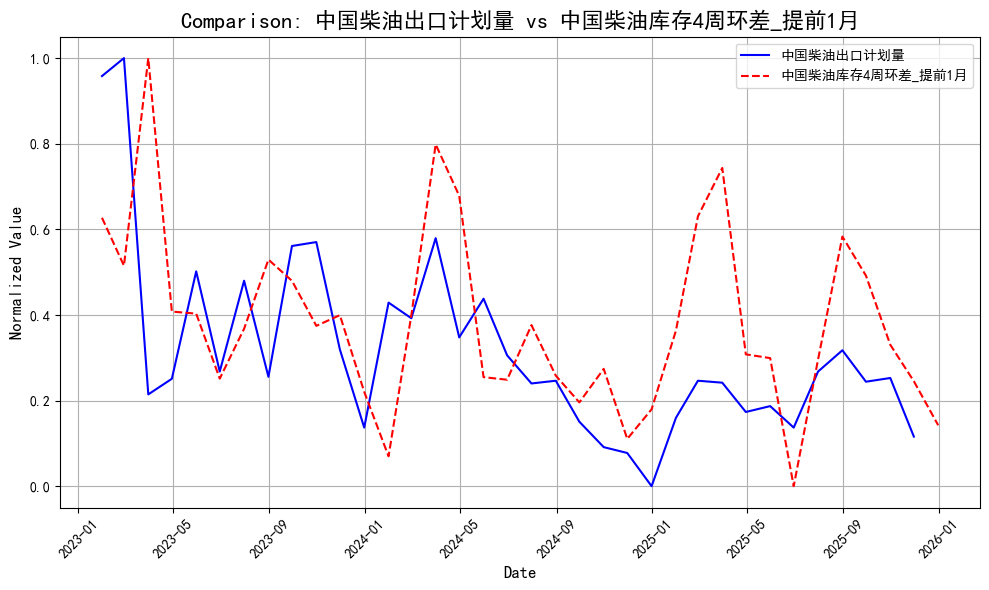

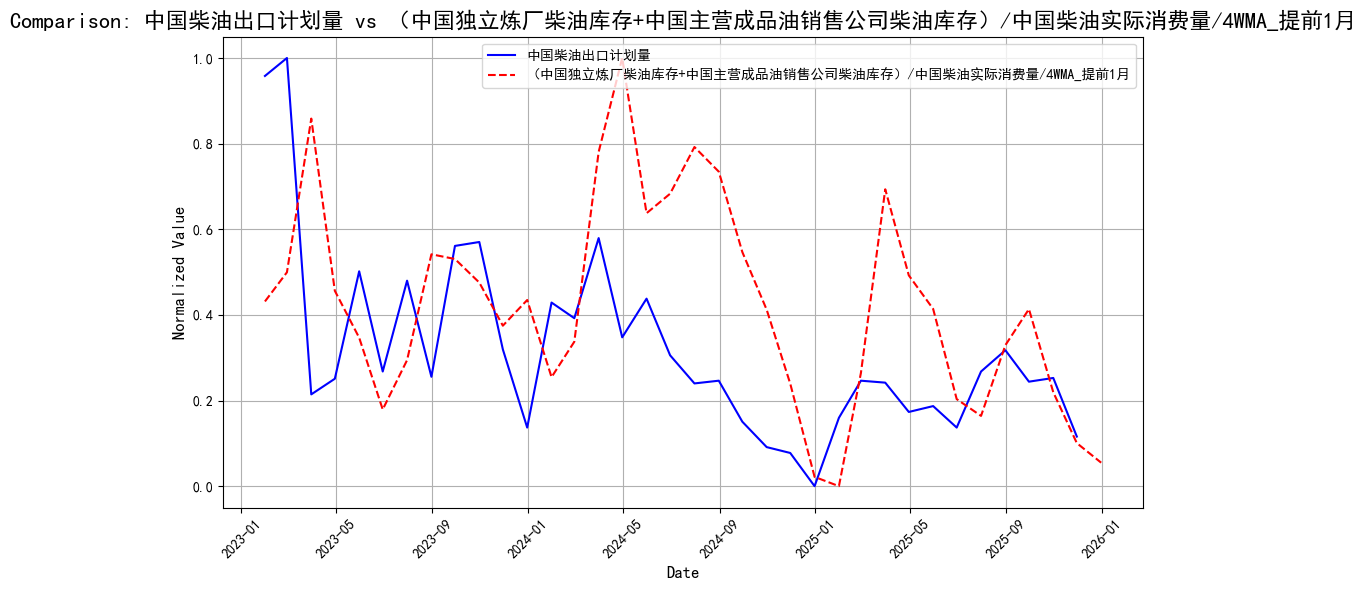

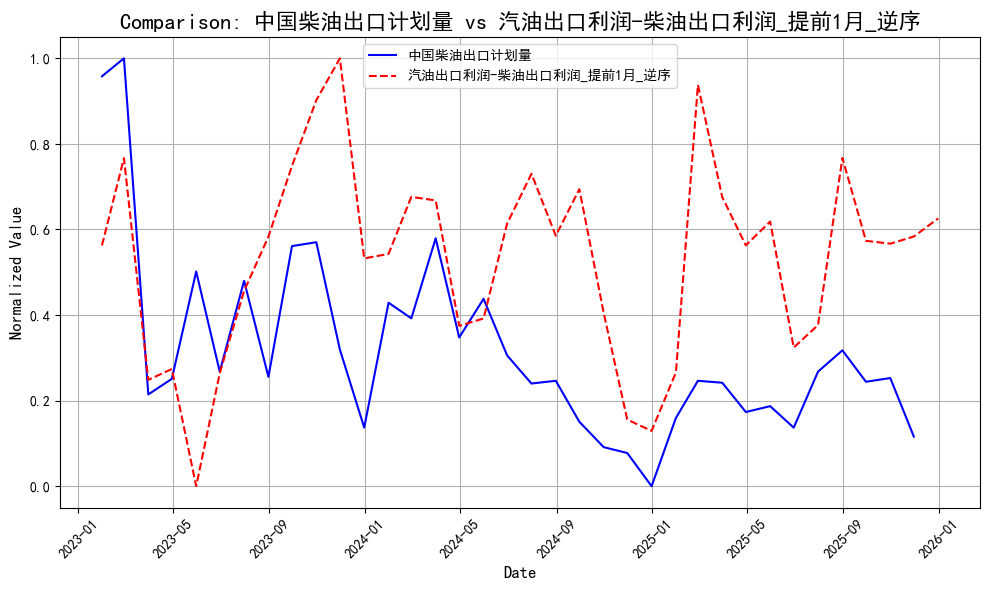

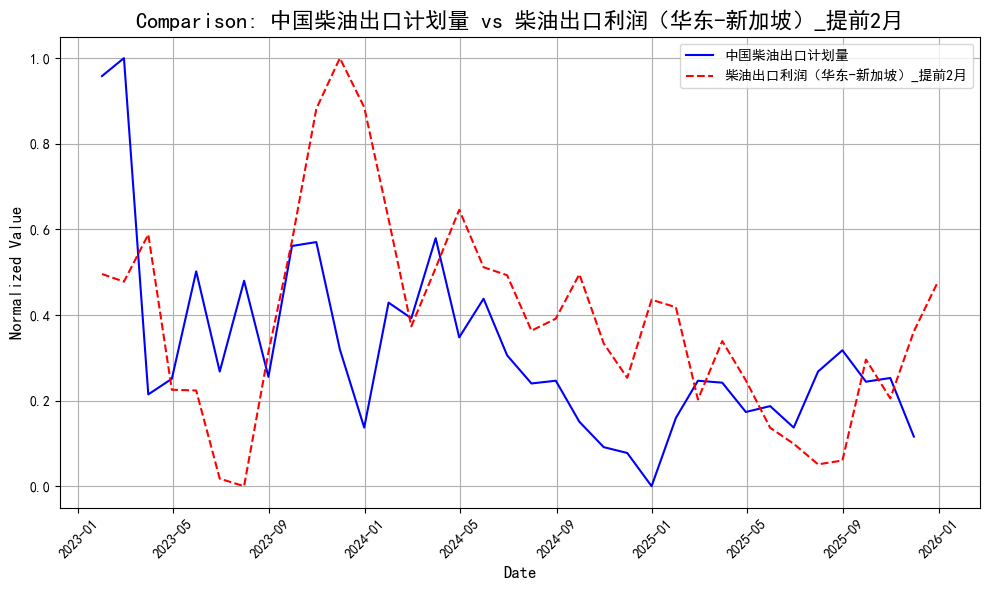

In [8]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='中国柴油出口计划量', 
    compare_cols=[
        '新加坡10ppm柴油裂解_提前2月',
        '柴油：主营炼厂：产量：中国（周）同差_提前2月',
        '中国柴油库存4周环差_提前1月',
        '（中国独立炼厂柴油库存+中国主营成品油销售公司柴油库存）/中国柴油实际消费量/4WMA_提前1月',
        '汽油出口利润-柴油出口利润_提前1月_逆序',
        '柴油出口利润（华东-新加坡）_提前2月'
    
        ]
)

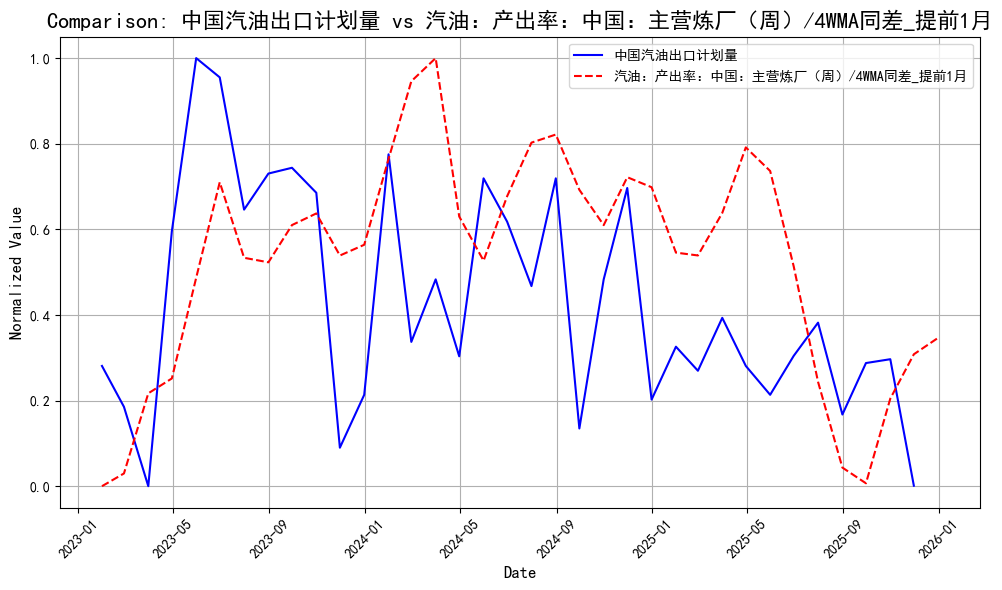

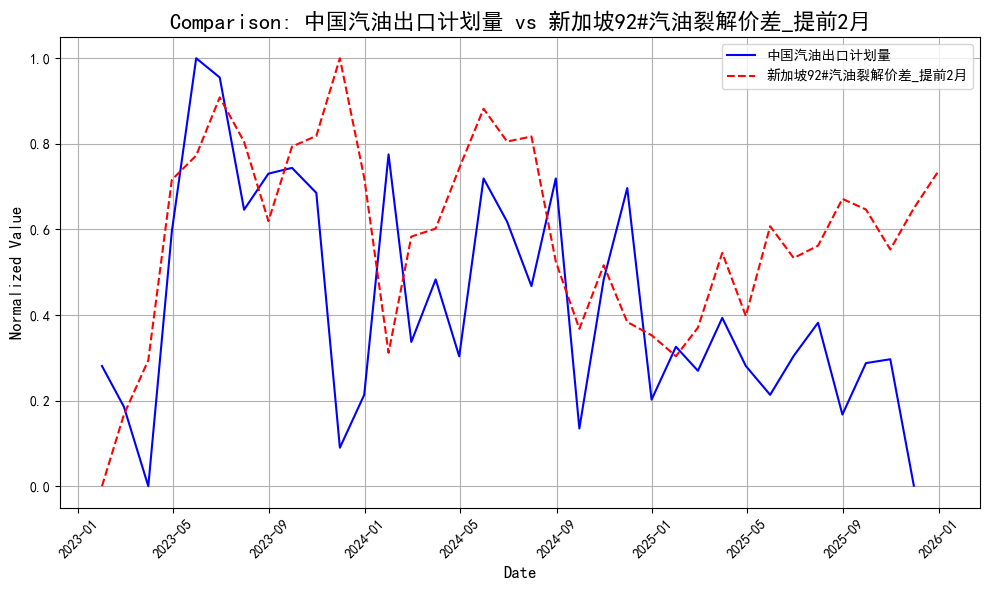

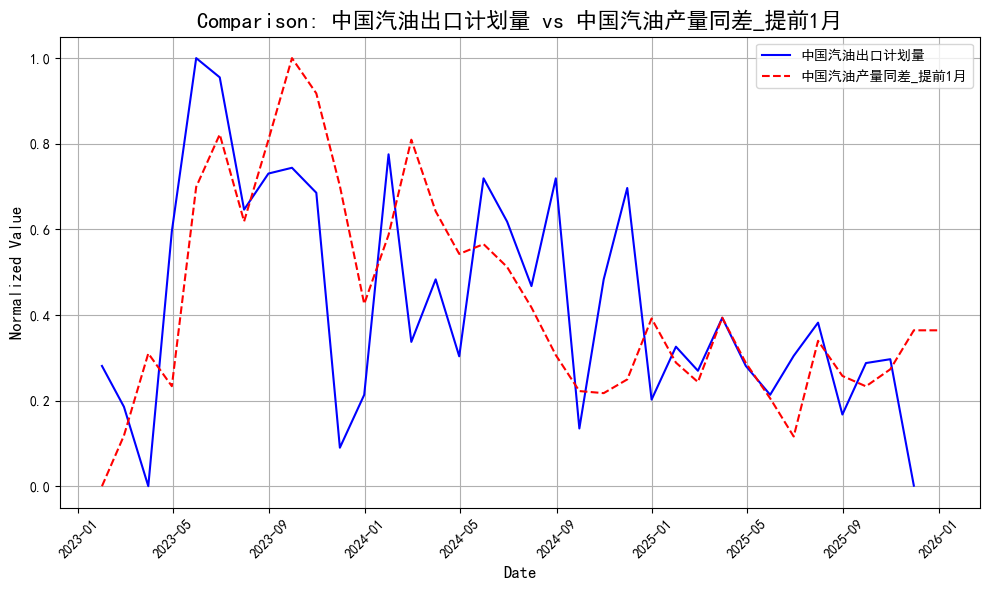

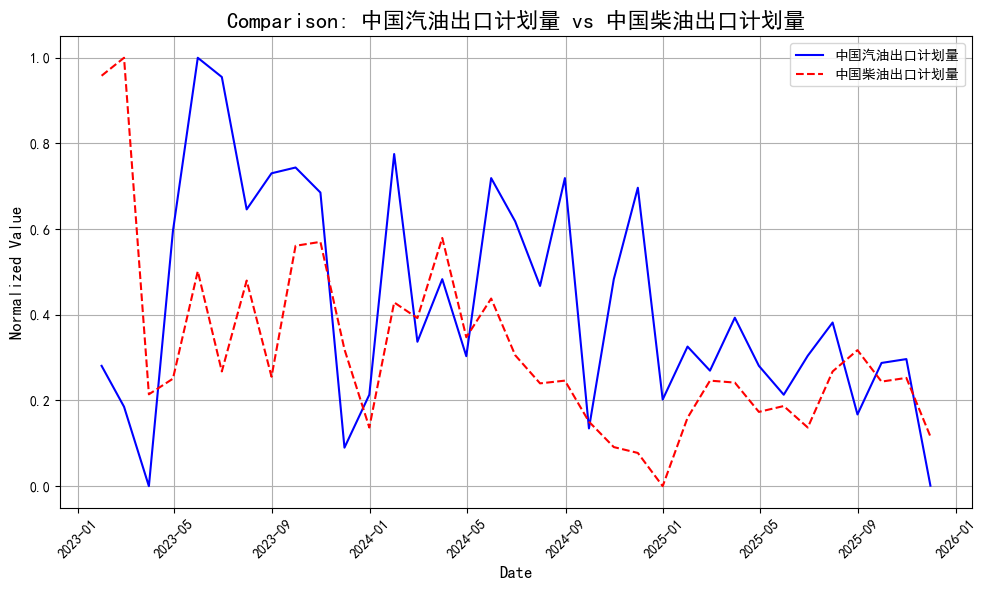

列 '汽油出口利润-柴油出口利润_提前2月中国柴油出口计划量' 不存在于 DataFrame 中。


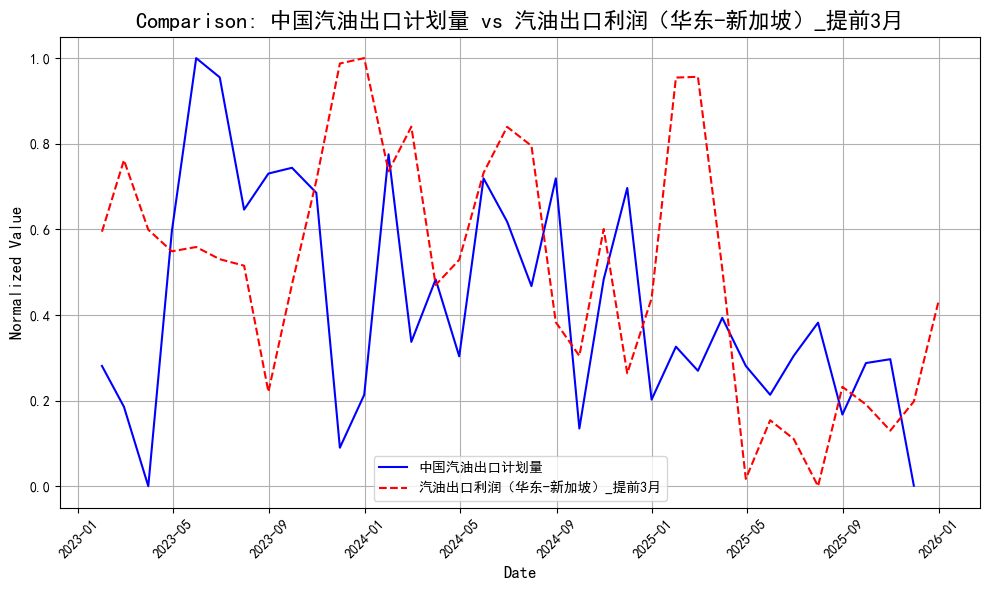

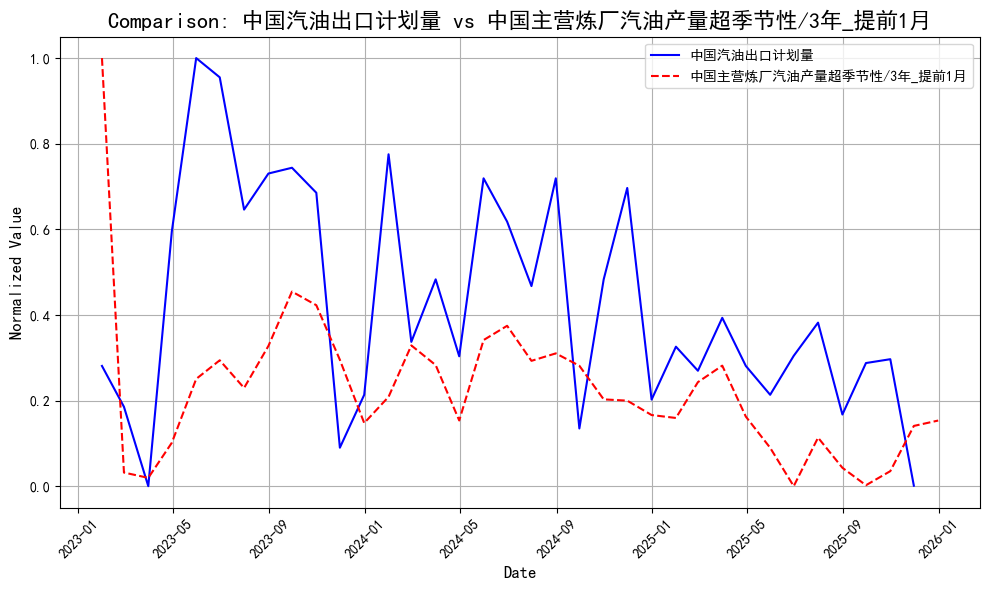

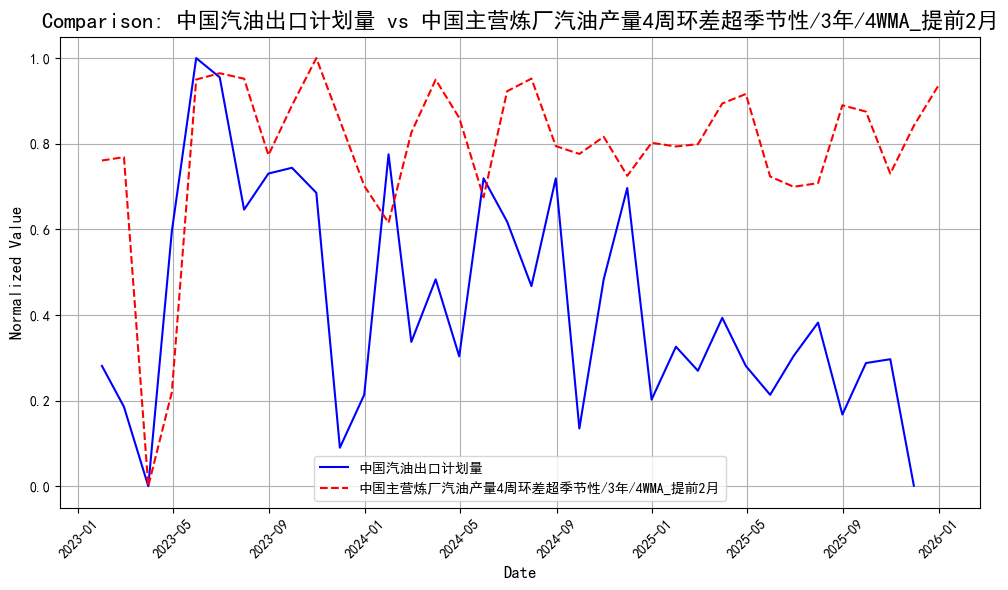

In [9]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='中国汽油出口计划量', 
    compare_cols=[
        '汽油：产出率：中国：主营炼厂（周）/4WMA同差_提前1月',
        '新加坡92#汽油裂解价差_提前2月',
        '中国汽油产量同差_提前1月',
        '中国柴油出口计划量',
        '汽油出口利润-柴油出口利润_提前2月'
        '中国柴油出口计划量',
        '汽油出口利润（华东-新加坡）_提前3月',
        '中国主营炼厂汽油产量超季节性/3年_提前1月',
        '中国主营炼厂汽油产量4周环差超季节性/3年/4WMA_提前2月'
        ]
)

In [10]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 2
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '新加坡10ppm柴油裂解_提前2月',
        '柴油：主营炼厂：产量：中国（周）同差_提前2月',
        '中国柴油库存4周环差_提前1月',
        '（中国独立炼厂柴油库存+中国主营成品油销售公司柴油库存）/中国柴油实际消费量/4WMA_提前1月',
        '汽油出口利润-柴油出口利润_提前1月_逆序',
        '柴油出口利润（华东-新加坡）_提前2月',
]

predict_column = '中国柴油出口计划量'



X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.03,  # 默认学习率
    'max_depth': 12,  # 默认树深度
    'min_child_weight': 1,  # 默认最小子节点权重
    'subsample': 0.8,  # 默认子采样比例
    'colsample_bytree': 0.8,  # 默认特征采样比例
    'gamma': 1,  # 默认最小分裂损失
    'reg_alpha': 0,  # 默认L1正则化
    'reg_lambda': 1,  # 默认L2正则化
    'eval_metric': 'rmse',  # 评估指标
    'seed': 42,  # 随机种子
#    'tree_method': 'auto'  # 默认树方法
}


num_boost_round = 2000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:29.35653	train-rmse:38.61244


[500]	eval-rmse:18.93137	train-rmse:1.08301


[1000]	eval-rmse:18.96408	train-rmse:0.76726


[1500]	eval-rmse:18.95197	train-rmse:0.72243


[1999]	eval-rmse:18.96417	train-rmse:0.69112


训练集 MSE (DMatrix): 0.8367, 训练集 R² (DMatrix): 0.9996
测试集 MSE (DMatrix): 359.6396, 测试集 R² (DMatrix): -0.5984


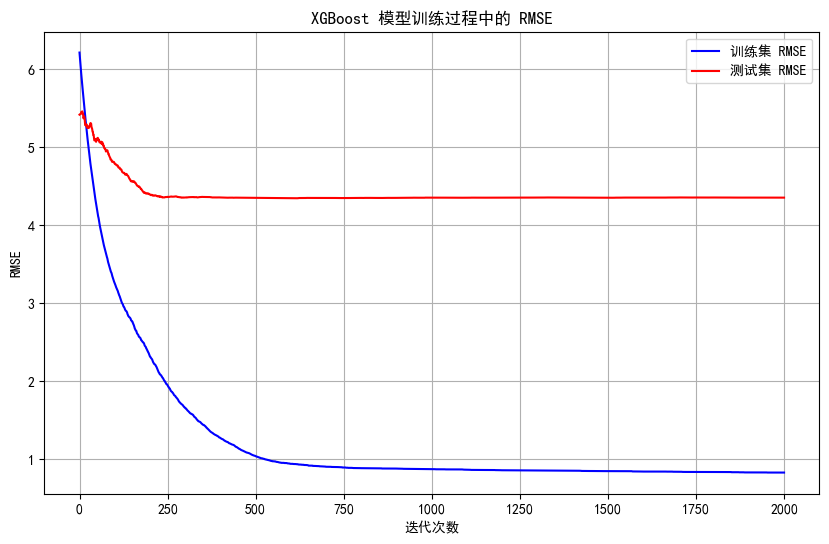

In [11]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all


[0]	train-rmse:38.03811


[500]	train-rmse:1.06831


[1000]	train-rmse:0.74855


[1500]	train-rmse:0.70466


[1999]	train-rmse:0.67347


全部数据 MSE: 0.7854, 全部数据 R²: 0.9996


In [13]:
# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    future_data[['Date', '预测值_全量']],
    on='Date',
    how='left'
)
sheet_daily['中国柴油出口计划量'] = sheet_daily['中国柴油出口计划量'].fillna(sheet_daily['预测值_全量'])
sheet_daily = sheet_daily.drop(columns=['预测值_全量'])

In [14]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data_sub = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period_sub = 2
test_data_sub = train_data_sub[-test_period_sub:].copy() 
train_data_sub = train_data_sub[:-test_period_sub].copy()
future_data_sub = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns_sub = [
        #'汽油：产出率：中国：主营炼厂（周）/4WMA同差_提前1月',
        '新加坡92#汽油裂解价差_提前2月',
        '中国汽油产量同差_提前1月',
        '中国柴油出口计划量',
        '汽油出口利润-柴油出口利润_提前2月',
        '汽油出口利润（华东-新加坡）_提前3月',
        '中国主营炼厂汽油产量超季节性/3年_提前1月',
        '中国主营炼厂汽油产量4周环差超季节性/3年/4WMA_提前2月'
        ]

predict_column_sub = '中国汽油出口计划量'



X_train_sub = train_data_sub[feature_columns_sub]
y_train_sub = train_data_sub[predict_column_sub]

X_test_sub = test_data_sub[feature_columns_sub]
y_test_sub = test_data_sub[predict_column_sub]

X_future_sub = future_data_sub[feature_columns_sub]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler_sub = StandardScaler()
X_train_scaled_sub = scaler_sub.fit_transform(X_train_sub)
X_test_scaled_sub = scaler_sub.transform(X_test_sub)
X_future_scaled_sub = scaler_sub.transform(X_future_sub)

train_dmatrix_huber_sub = xgb.DMatrix(X_train_scaled_sub, label=y_train_sub)
train_dmatrix_zscore_sub = xgb.DMatrix(X_train_scaled_sub, label=y_train_sub)
test_dmatrix_sub = xgb.DMatrix(X_test_scaled_sub, label=y_test_sub)
future_dmatrix_sub = xgb.DMatrix(X_future_scaled_sub)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals_sub = np.abs(y_train_sub - y_train_sub.mean())
delta_sub = np.percentile(residuals_sub, 90)  # 使用90%分位数作为阈值
sample_weights_huber_sub = np.where(residuals_sub <= delta_sub, 1.0, delta_sub/residuals_sub)
train_dmatrix_huber_sub.set_weight(sample_weights_huber_sub)

# 使用z-score思路计算样本权重
z_scores_sub = np.abs((y_train_sub - y_train_sub.mean()) / y_train_sub.std())
z_threshold_sub = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore_sub = np.where(z_scores_sub <= z_threshold_sub, 1.0, z_threshold_sub/z_scores_sub)
train_dmatrix_zscore_sub.set_weight(sample_weights_zscore_sub)

# 设置XGBoost参数
params_sub = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.01,  # 默认学习率
    'max_depth': 9,  # 默认树深度
    'min_child_weight': 0.71,  # 默认最小子节点权重
    'subsample': 0.8,  # 默认子采样比例
    'colsample_bytree': 0.8,  # 默认特征采样比例
    'gamma': 0.03,  # 默认最小分裂损失
    'reg_alpha': 0.7,  # 默认L1正则化
    'reg_lambda': 0.9,  # 默认L2正则化
    'eval_metric': 'rmse',  # 评估指标
    'seed': 42,  # 随机种子
#    'tree_method': 'auto'  # 默认树方法
}


num_boost_round_sub = 3000
evals_result_sub = {}

# 模型训练
model_sub = xgb.train(
    params_sub,
    train_dmatrix_huber_sub,  # 使用带权重的DMatrix
    num_boost_round_sub, # 训练最大轮数
    evals=[(test_dmatrix_sub, 'eval'), (train_dmatrix_huber_sub, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result_sub,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix_sub = model_sub.predict(train_dmatrix_huber_sub)
y_test_pred_dmatrix_sub = model_sub.predict(test_dmatrix_sub)

train_mse_sub = mean_squared_error(y_train_sub, y_train_pred_dmatrix_sub)
test_mse_sub = mean_squared_error(y_test_sub, y_test_pred_dmatrix_sub)
train_r2_sub = r2_score(y_train_sub, y_train_pred_dmatrix_sub)
test_r2_sub = r2_score(y_test_sub, y_test_pred_dmatrix_sub)
print(f"训练集 MSE (DMatrix): {round(train_mse_sub, 4)}, 训练集 R² (DMatrix): {round(train_r2_sub, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse_sub, 4)}, 测试集 R² (DMatrix): {round(test_r2_sub, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix_sub = model_sub.predict(future_dmatrix_sub)
test_data_sub.loc[:, '预测值'] = y_test_pred_dmatrix_sub
future_data_sub.loc[:, '预测值'] = y_future_pred_dmatrix_sub

[0]	eval-rmse:28.67262	train-rmse:21.43794


[500]	eval-rmse:16.42245	train-rmse:2.08172


[1000]	eval-rmse:15.93669	train-rmse:0.56854


[1500]	eval-rmse:15.88390	train-rmse:0.34784


[2000]	eval-rmse:15.88313	train-rmse:0.31574


[2500]	eval-rmse:15.88972	train-rmse:0.30477


[2999]	eval-rmse:15.89033	train-rmse:0.29883


训练集 MSE (DMatrix): 0.1151, 训练集 R² (DMatrix): 0.9998
测试集 MSE (DMatrix): 252.5026, 测试集 R² (DMatrix): -0.4602


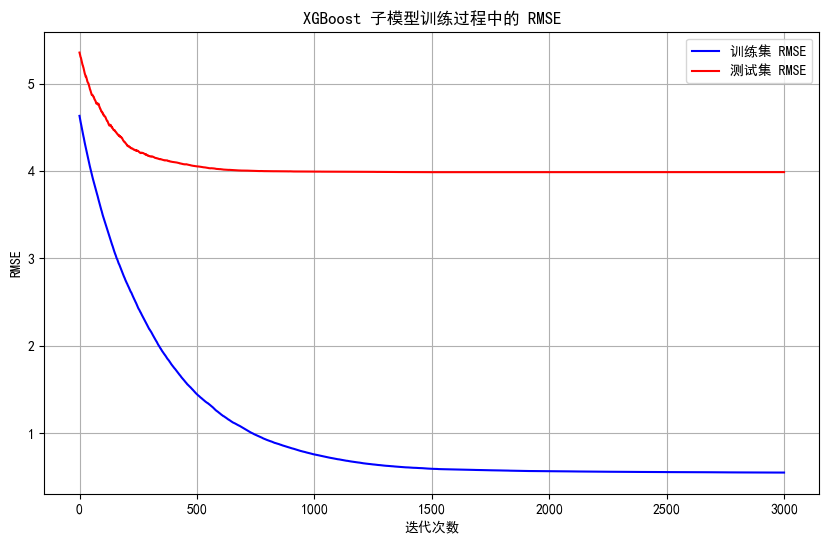

In [15]:
# 可视化训练过程中的评估指标（子模型）
plt.figure(figsize=(10, 6))
train_rmse_sub = np.sqrt(evals_result_sub['train']['rmse'])
test_rmse_sub = np.sqrt(evals_result_sub['eval']['rmse'])

epochs_sub = len(train_rmse_sub)
x_axis_sub = range(epochs_sub)

plt.plot(x_axis_sub, train_rmse_sub, label='训练集 RMSE', color='blue')
plt.plot(x_axis_sub, test_rmse_sub, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 子模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
################################# Xgboost 子模型 训练 测试 预测 所有数据 #################################
X_all_sub = pd.concat([X_train_sub, X_test_sub]).reset_index(drop=True)
y_all_sub = pd.concat([y_train_sub, y_test_sub]).reset_index(drop=True)

X_all_scaled_sub = scaler_sub.transform(X_all_sub)
X_future_scaled_sub = scaler_sub.transform(X_future_sub)

# 创建 DMatrix 对象
all_data_dmatrix_sub = xgb.DMatrix(X_all_scaled_sub, label=y_all_sub)
future_dmatrix_all_sub = xgb.DMatrix(X_future_scaled_sub)

# 计算所有数据的样本权重
residuals_all_sub = np.abs(y_all_sub - y_all_sub.mean())
delta_sub_all = np.percentile(residuals_all_sub, 90)  # 与子模型一致，使用90分位数
sample_weights_all_sub = np.where(residuals_all_sub <= delta_sub_all, 1.0, delta_sub_all / residuals_all_sub)

all_data_dmatrix_sub.set_weight(sample_weights_all_sub)  # 加入样本权重

# 训练模型
evals_result_all_sub = {}
model_all_sub = xgb.train(
    params_sub,
    all_data_dmatrix_sub,
    num_boost_round_sub,
    evals=[(all_data_dmatrix_sub, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result_all_sub,
    verbose_eval=500
)

y_all_pred_sub = model_all_sub.predict(all_data_dmatrix_sub)
y_future_pred_all_sub = model_all_sub.predict(future_dmatrix_all_sub)

all_mse_sub = mean_squared_error(y_all_sub, y_all_pred_sub)
all_r2_sub = r2_score(y_all_sub, y_all_pred_sub)

print(f"全部数据 MSE (子模型): {round(float(all_mse_sub), 4)}, 全部数据 R² (子模型): {round(float(all_r2_sub), 4)}")

# 存储全部数据的预测结果
all_data_sub = pd.concat([train_data_sub, test_data_sub]).reset_index(drop=True)
all_data_sub.loc[:, '预测值_全量'] = y_all_pred_sub
future_data_sub.loc[:, '预测值_全量'] = y_future_pred_all_sub


[0]	train-rmse:22.07473


[500]	train-rmse:1.93969


[1000]	train-rmse:0.48666


[1500]	train-rmse:0.31791


[2000]	train-rmse:0.29478


[2500]	train-rmse:0.28454


[2999]	train-rmse:0.27872


全部数据 MSE (子模型): 0.0928, 全部数据 R² (子模型): 0.9998


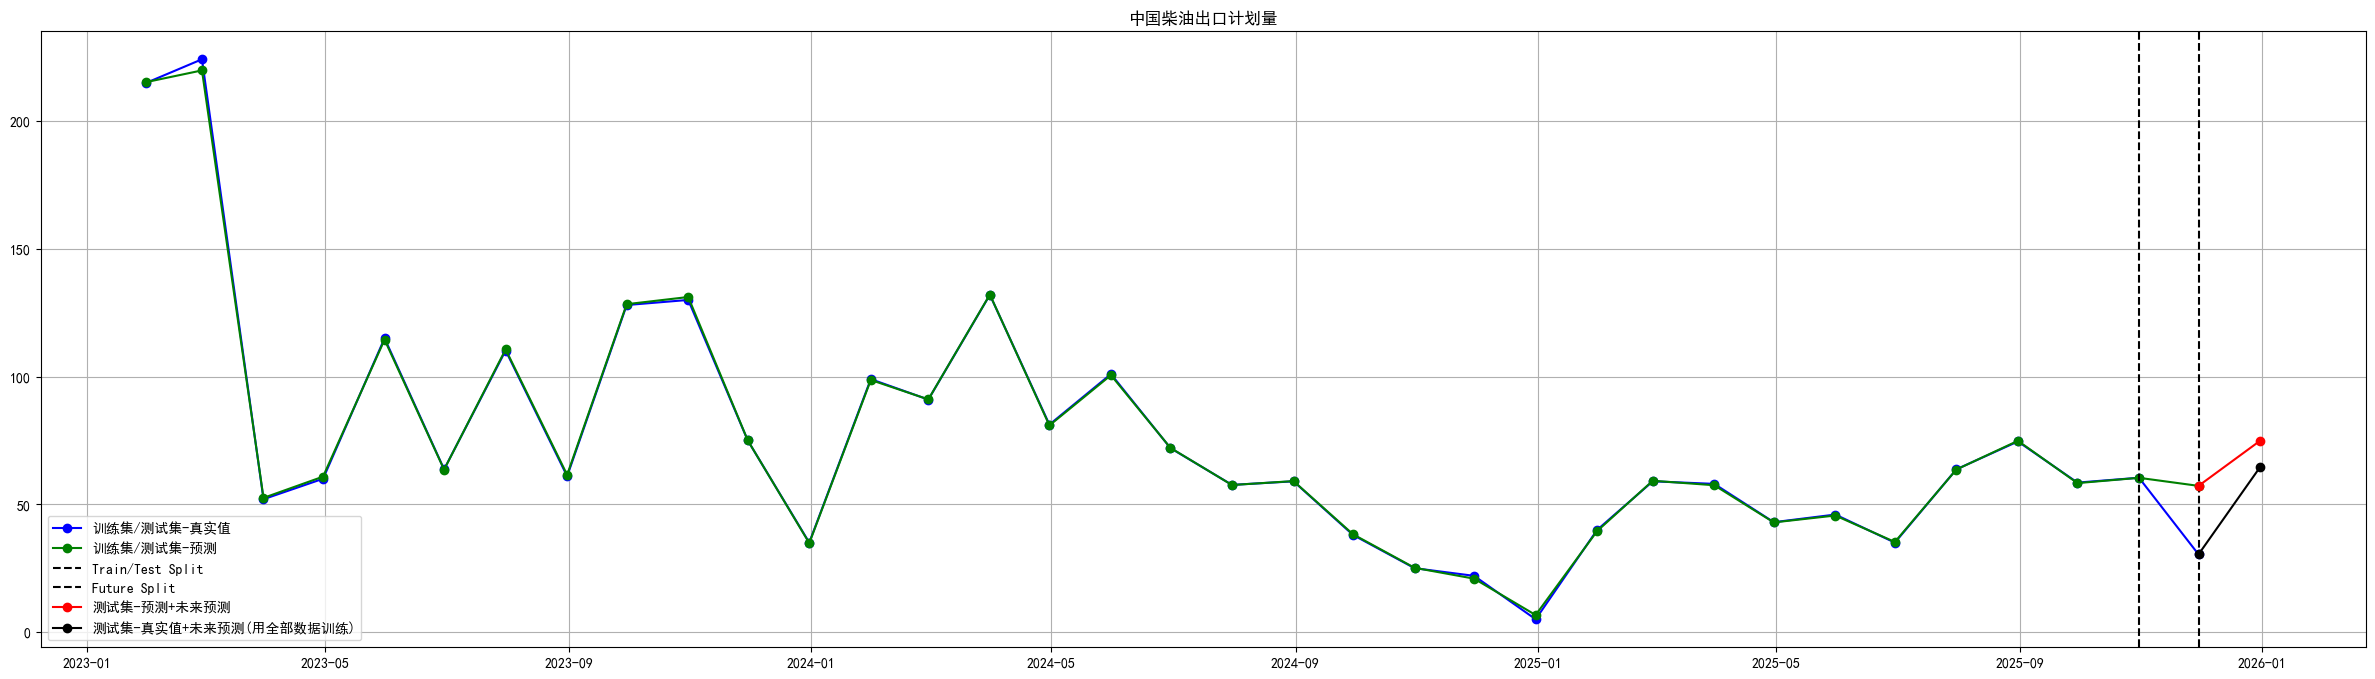

In [17]:
plt.figure(figsize=(30, 8))

# 真实值（训练+测试）
all_dates = pd.concat([train_data['Date'], test_data['Date']])
all_true = pd.concat([pd.Series(y_train, index=train_data.index), pd.Series(y_test, index=test_data.index)])

# 预测值（训练+测试）
all_pred = pd.concat([pd.Series(y_train_pred_dmatrix, index=train_data.index), pd.Series(y_test_pred_dmatrix, index=test_data.index)])

# 分割线位置
split_date = test_data['Date'].iloc[0]

# 蓝线：真实值（训练+测试）
plt.plot(all_dates, all_true, '-o', label='训练集/测试集-真实值', color='blue')

# 绿线：预测值（训练+测试）
plt.plot(all_dates, all_pred, '-o', label='训练集/测试集-预测', color='green')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 找到分割点索引
split_idx = all_dates[all_dates == split_date].index[-1] + 1

# 未来预测（红线与绿线连接，黑线与蓝线连接）
all_pred_full = pd.concat([all_pred, future_data['预测值']])
all_dates_full = pd.concat([all_dates, future_data['Date']])
plt.plot(all_dates_full.iloc[split_idx:], all_pred_full.iloc[split_idx:], '-o', label='测试集-预测+未来预测', color='red')

all_pred_full_all = pd.concat([all_true, future_data['预测值_全量']])
plt.plot(all_dates_full.iloc[split_idx:], all_pred_full_all.iloc[split_idx:], '-o', label='测试集-真实值+未来预测(用全部数据训练)', color='black')

plt.title('中国柴油出口计划量')
plt.legend()
plt.grid(True)
plt.show()

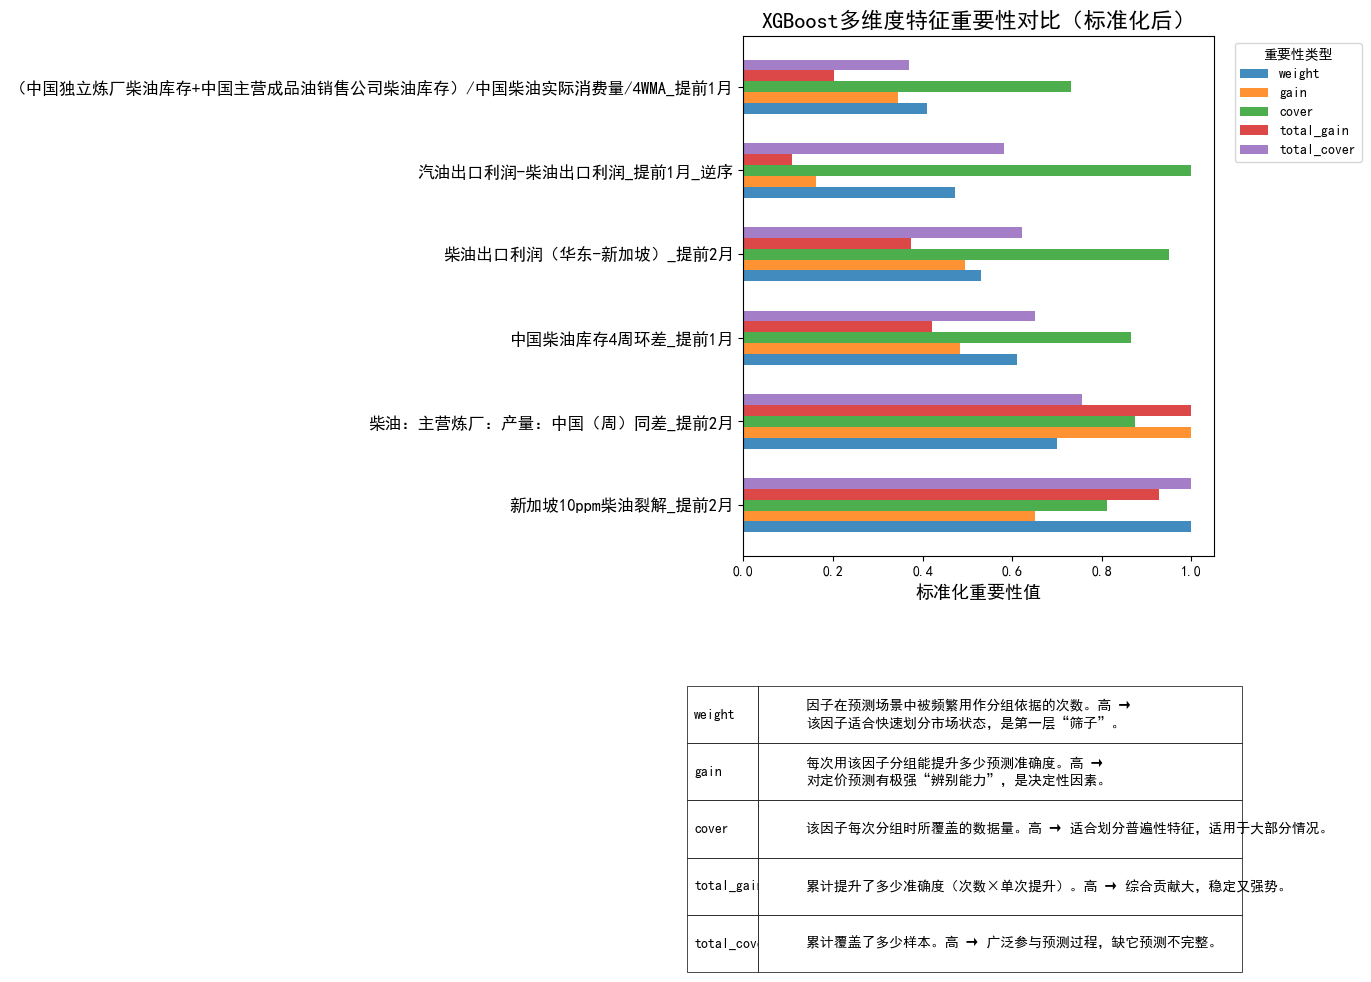

,weight,gain,cover,total_gain,total_cover
新加坡10ppm柴油裂解_提前2月,1.000000,0.651501,0.811070,0.929083,1.000000
柴油：主营炼厂：产量：中国（周）同差_提前2月,0.701230,1.000000,0.874461,1.000000,0.756036
中国柴油库存4周环差_提前1月,0.610721,0.482873,0.865290,0.420547,0.651547
柴油出口利润（华东-新加坡）_提前2月,0.530756,0.494797,0.951165,0.374508,0.622433
汽油出口利润-柴油出口利润_提前1月_逆序,0.471880,0.161981,1.000000,0.109003,0.581800
（中国独立炼厂柴油库存+中国主营成品油销售公司柴油库存）/中国柴油实际消费量/4WMA_提前1月,0.410369,0.344169,0.731586,0.201412,0.370153


In [18]:
#绘制因子重要性
plot_xgb_feature_importance(model_all, X_train)

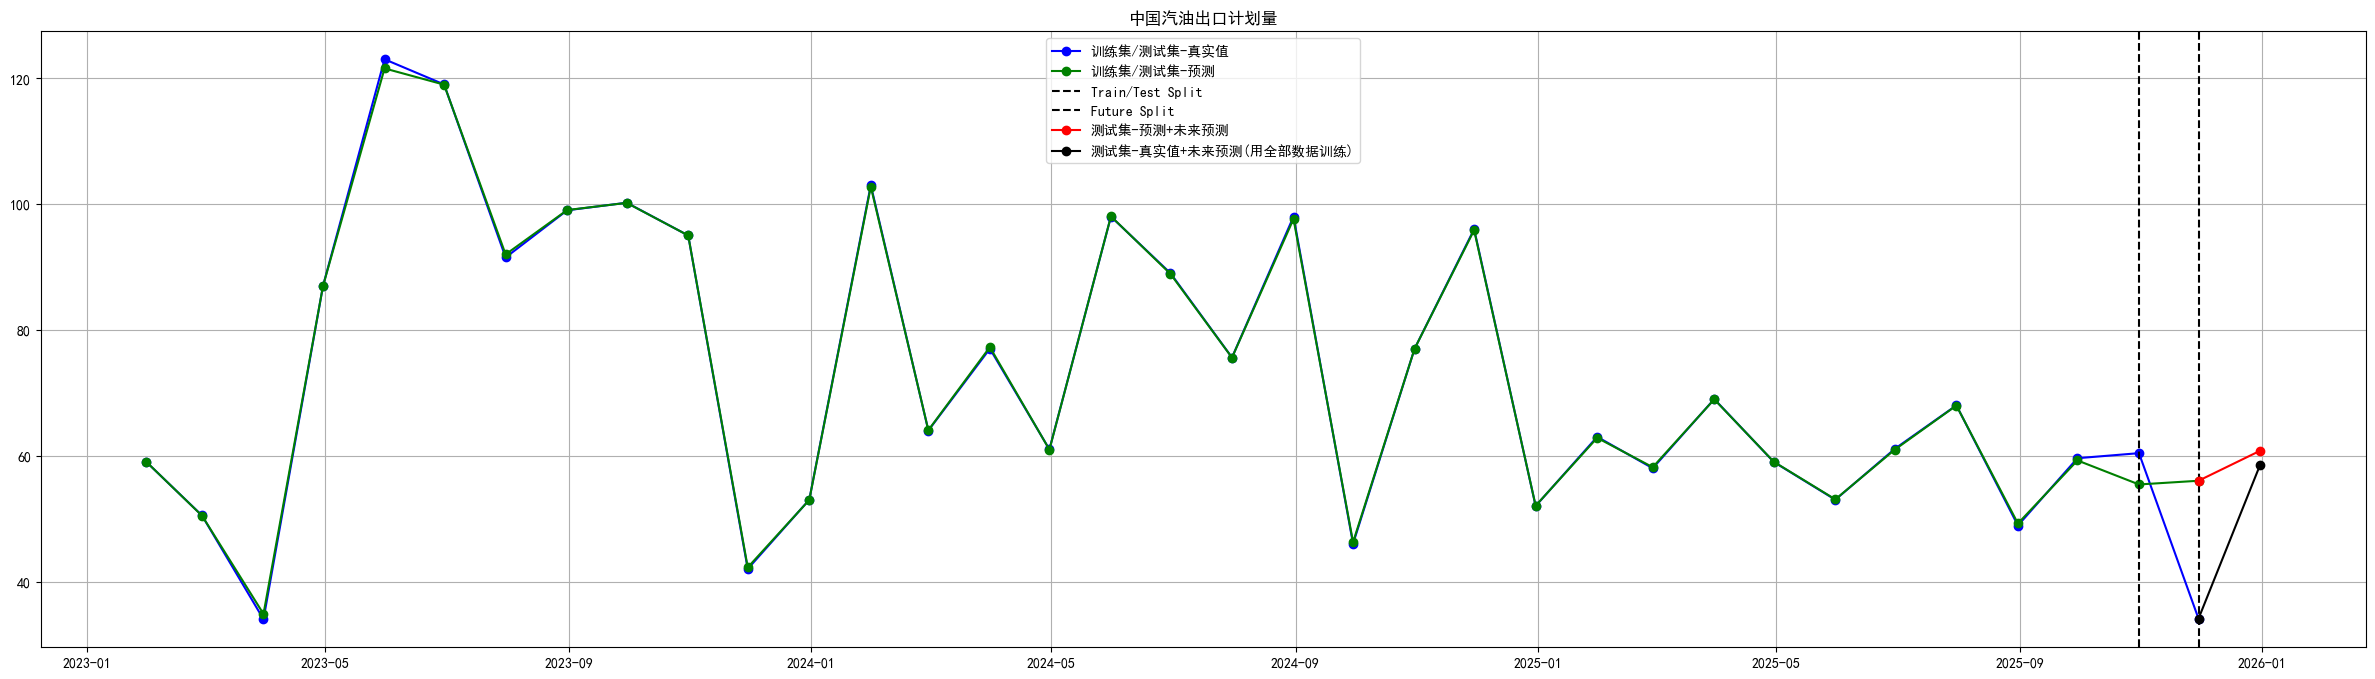

In [19]:
plt.figure(figsize=(30, 8))

# 真实值（训练+测试）
all_dates_sub = pd.concat([train_data_sub['Date'], test_data_sub['Date']])
all_true_sub = pd.concat([pd.Series(y_train_sub, index=train_data_sub.index), pd.Series(y_test_sub, index=test_data_sub.index)])

# 预测值（训练+测试）
all_pred_sub = pd.concat([pd.Series(y_train_pred_dmatrix_sub, index=train_data_sub.index), pd.Series(y_test_pred_dmatrix_sub, index=test_data_sub.index)])

# 分割线位置
split_date_sub = test_data_sub['Date'].iloc[0]

# 蓝线：真实值（训练+测试）
plt.plot(all_dates_sub, all_true_sub, '-o', label='训练集/测试集-真实值', color='blue')

# 绿线：预测值（训练+测试）
plt.plot(all_dates_sub, all_pred_sub, '-o', label='训练集/测试集-预测', color='green')

# 添加分割线
plt.axvline(x=test_data_sub['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 找到分割点索引
split_idx_sub = all_dates_sub[all_dates_sub == split_date_sub].index[-1] + 1

# 未来预测（红线与绿线连接，黑线与蓝线连接）
all_pred_full_sub = pd.concat([all_pred_sub, future_data_sub['预测值']])
all_dates_full_sub = pd.concat([all_dates_sub, future_data_sub['Date']])
plt.plot(all_dates_full_sub.iloc[split_idx_sub:], all_pred_full_sub.iloc[split_idx_sub:], '-o', label='测试集-预测+未来预测', color='red')

all_pred_full_all_sub = pd.concat([all_true_sub, future_data_sub['预测值_全量']])
plt.plot(all_dates_full_sub.iloc[split_idx_sub:], all_pred_full_all_sub.iloc[split_idx_sub:], '-o', label='测试集-真实值+未来预测(用全部数据训练)', color='black')

plt.title('中国汽油出口计划量')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/中国柴油出口计划量_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
35,2025/12/31,NaN,64.542435
34,2025/11/30,30.4,NaN
33,2025/10/31,60.4,NaN
32,2025/09/30,58.5,NaN
31,2025/08/31,74.6,NaN
30,2025/07/31,63.7,NaN
29,2025/06/30,35.0,NaN
28,2025/05/31,46.0,NaN
27,2025/04/30,43.0,NaN
26,2025/03/31,58.0,NaN


In [21]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2024]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2025]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2025]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/中国柴油出口计划量_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly

,Date,真实值,预测值
23,2025/12/31,NaN,64.542435
22,2025/11/30,30.4,57.219368
21,2025/10/31,60.4,60.373444
20,2025/09/30,58.5,58.299088
19,2025/08/31,74.6,74.855705
18,2025/07/31,63.7,63.615112
17,2025/06/30,35.0,35.256042
16,2025/05/31,46.0,45.616508
15,2025/04/30,43.0,42.915218
14,2025/03/31,58.0,57.470581


In [22]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily_sub = pd.DataFrame({
    'Date': pd.concat([train_data_sub['Date'], test_data_sub['Date']]),
    '真实值': pd.concat([y_train_sub, y_test_sub])
})
# 只保留2023年之后的数据
historical_actual_daily_sub = historical_actual_daily_sub[historical_actual_daily_sub['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily_sub = pd.DataFrame({
    'Date': future_data_sub['Date'],
    '预测值': future_data_sub['预测值_全量']
})


merged_df_daily_sub = pd.merge(historical_actual_daily_sub, future_pred_daily_sub, on='Date', how='outer')
merged_df_daily_sub = merged_df_daily_sub.sort_values('Date', ascending=False)
merged_df_daily_sub['Date'] = merged_df_daily_sub['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily_sub.to_excel('eta/中国汽油出口计划量_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily_sub

,Date,真实值,预测值
35,2025/12/31,NaN,58.510696
34,2025/11/30,34.1,NaN
33,2025/10/31,60.4,NaN
32,2025/09/30,59.6,NaN
31,2025/08/31,48.9,NaN
30,2025/07/31,68.0,NaN
29,2025/06/30,61.1,NaN
28,2025/05/31,53.0,NaN
27,2025/04/30,59.0,NaN
26,2025/03/31,69.0,NaN


In [23]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly_sub = pd.DataFrame({
    'Date': pd.concat([train_data_sub['Date'], test_data_sub['Date']]),
    '真实值': pd.concat([y_train_sub, y_test_sub])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly_sub = historical_actual_monthly_sub[historical_actual_monthly_sub['Date'].dt.year >= 2024]
# 2024年及以后训练集预测值
train_pred_2024_sub = pd.DataFrame({
    'Date': train_data_sub[train_data_sub['Date'].dt.year >= 2025]['Date'],
    '预测值': y_train_pred_dmatrix_sub[train_data_sub['Date'].dt.year >= 2025]
})
# 2024年及以后c测试集集预测值
test_pred_2024_sub = test_data_sub[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024_sub = pd.DataFrame({
    'Date': future_data_sub['Date'],
    '预测值': future_data_sub['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly_sub = pd.concat([
    train_pred_2024_sub, 
    test_pred_2024_sub, 
    future_pred_2024_sub
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly_sub = pd.merge(historical_actual_monthly_sub, future_pred_monthly_sub, on='Date', how='outer')
merged_df_monthly_sub.set_index('Date', inplace=True)
merged_df_monthly_sub = merged_df_monthly_sub.resample('ME').mean()
merged_df_monthly_sub.reset_index(inplace=True)
merged_df_monthly_sub =merged_df_monthly_sub.sort_values('Date', ascending=False)
merged_df_monthly_sub['Date'] = merged_df_monthly_sub['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly_sub.to_excel('eta/中国柴油出口计划量_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly_sub

,Date,真实值,预测值
23,2025/12/31,NaN,58.510696
22,2025/11/30,34.1,56.014957
21,2025/10/31,60.4,55.426075
20,2025/09/30,59.6,59.244389
19,2025/08/31,48.9,49.222553
18,2025/07/31,68.0,67.973633
17,2025/06/30,61.1,60.968758
16,2025/05/31,53.0,53.055592
15,2025/04/30,59.0,59.030544
14,2025/03/31,69.0,68.952957


In [24]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "中国汽油出口计划量"

# 调用函数更新数据
success = update_excel_data(merged_df_daily_sub, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [25]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "中国汽油出口计划量"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly_sub, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [26]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "中国柴油出口计划量"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [27]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "中国柴油出口计划量"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
